# Inspector

Inspecting the generated ASTs.

In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import json
import os
import joblib
from operator import itemgetter
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.colors as mcolors

In [371]:
DATA_PATH = 'data/code-sample/graph/'

## Load data

### Features

In [372]:
feats = np.load(DATA_PATH+'feats.npy')
feats.shape

(35, 102)

### Graph

In [373]:
G_data = json.load(open(DATA_PATH + "G.json"))
G = json_graph.node_link_graph(G_data)
print(G.number_of_nodes(), G.number_of_edges())

35 39


### Node id map

In [374]:
node_id_map = json.load(open(DATA_PATH + "id_map.json"))

### File map

In [375]:
file_map = json.load(open(DATA_PATH + "file_map.json"))

### Source-code line map

In [376]:
source_map = json.load(open(DATA_PATH + "source_map.json"))

### Parse map

In [377]:
parse_map = json.load(open(DATA_PATH + "parse_map.json"))

### AST Token maps

In [378]:
ast_symbol_dict = joblib.load(filename='ast_symbol_dict')
inv_ast_symbol_dict = joblib.load(filename='inv_ast_symbol_dict')

---

## Helpers

In [379]:
def get_name_from_token(token, show_id=True):
    tokenid  = np.nonzero(token)[0][0]
    return get_name_from_token_id(tokenid, show_id=show_id)

In [380]:
def get_name_from_token_id(tokenid, show_id = True):
    strtoken = inv_ast_symbol_dict.get(tokenid)
    
    if strtoken is None:
        strtoken = "<Unknown token>"
    else:
        strtoken = strtoken.__name__
        
    if show_id is True:
        strtoken += " " + str(tokenid) 
        
    return strtoken

In [381]:
def inspect_node_recursive(node_id, G, feats, depth=0):
    '''
    Recursively print neighbouring node tokens
    '''
    neighbours = list(G.adj[node_id])
    for i,token in enumerate(feats[neighbours]):
        strtoken = get_name_from_token(token)
        print(" "*depth, strtoken)
        if depth < 2:
            inspect_node_recursive(i, G, feats, depth+1)

In [382]:
# Example usage
inspect_node_recursive(1, G=G, feats=feats)

 Module 0
  Expr 24
   Expr 24
   Import 20
   FunctionDef 4
   If 14
  Import 20
   Module 0
   Str 45
  FunctionDef 4
   Expr 24
  If 14
   Module 0
   alias 101
 Str 45
  Module 0
   Expr 24
   Import 20
   FunctionDef 4
   If 14
  Str 45
   Module 0
   Str 45


In [383]:
def draw_egonet(node_id=1009, radius=2):
    node_and_degree = G.degree()
    hub_ego = nx.ego_graph(G, node_id, radius=radius)
    # Draw graph
    pos = nx.spring_layout(hub_ego)

    neighbours = list(hub_ego.nodes())
    labels = {}
    for n in neighbours:
        labels[n] = get_name_from_token(feats[n], show_id=False)

    nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=True, labels=labels)
    # Draw ego as large and red
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[node_id], node_size=300, node_color='r')
    plt.show()
    return neighbours

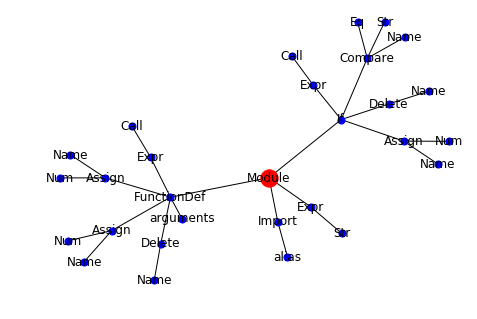

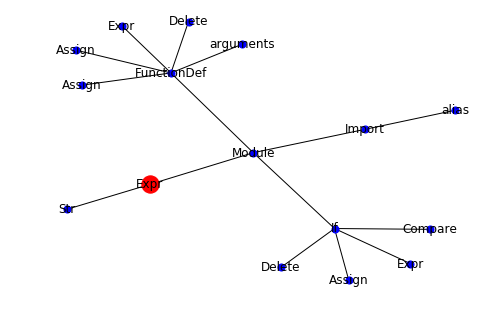

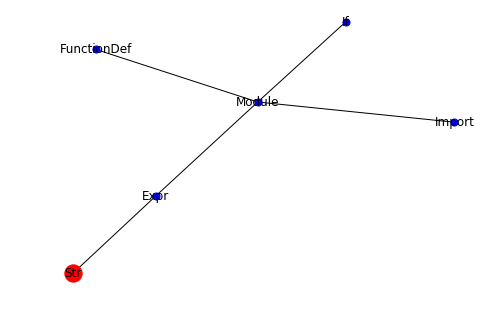

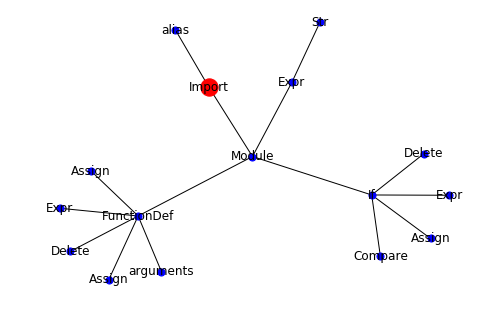

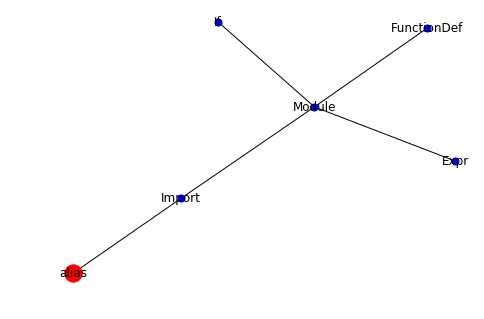

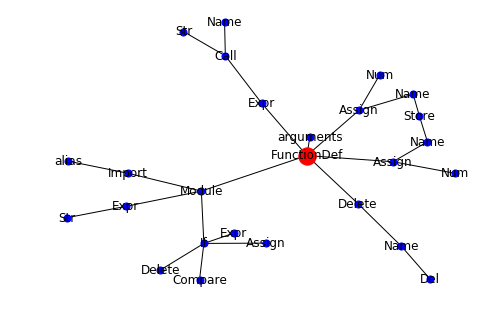

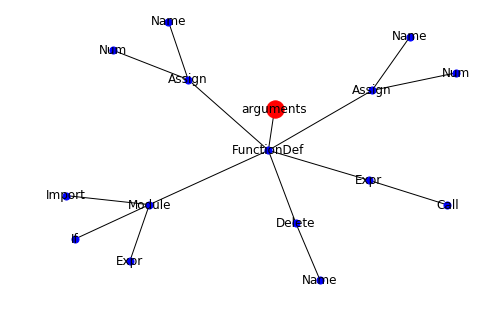

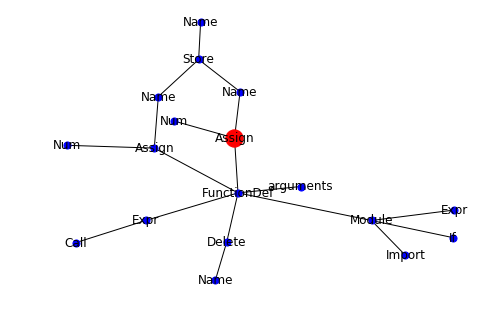

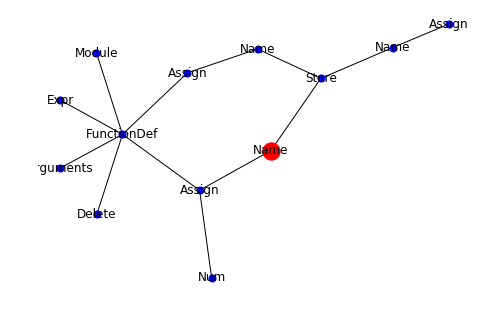

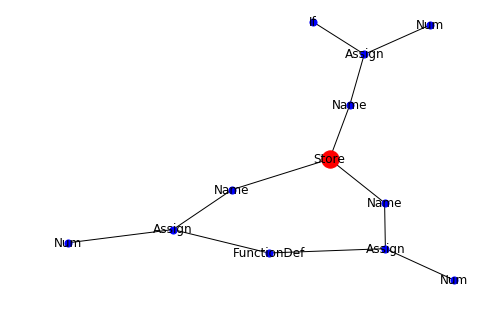

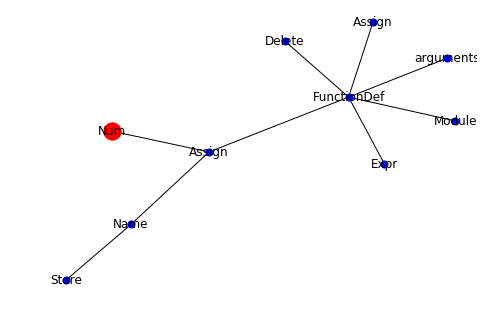

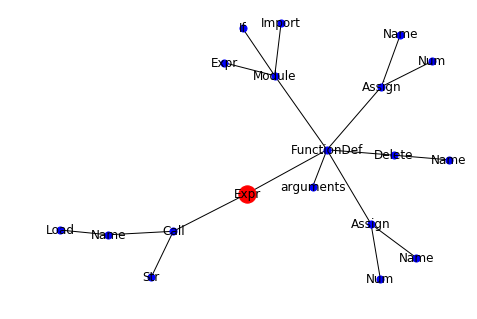

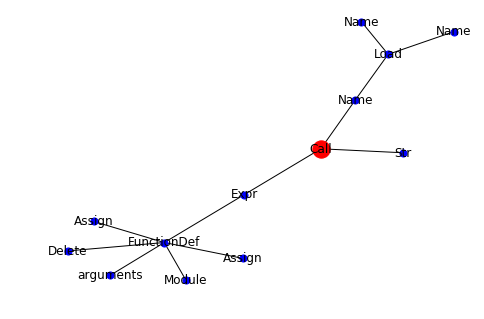

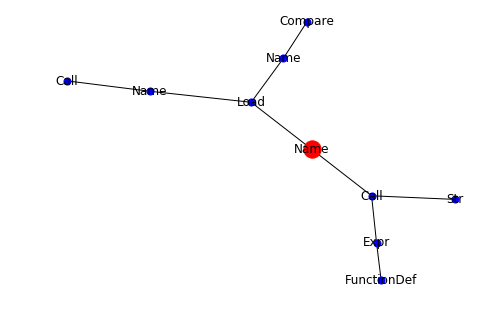

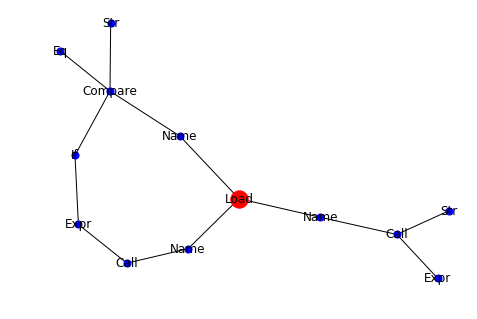

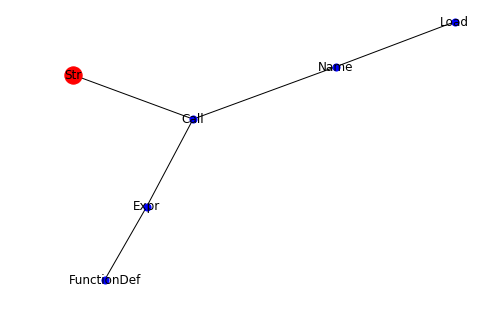

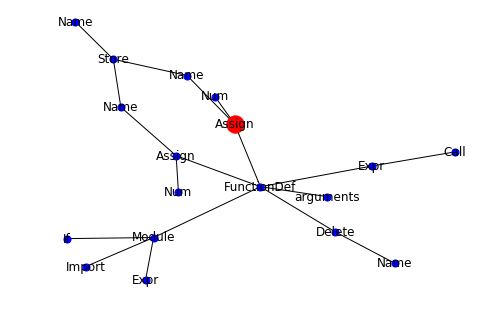

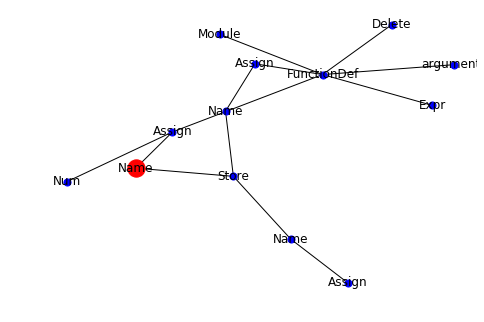

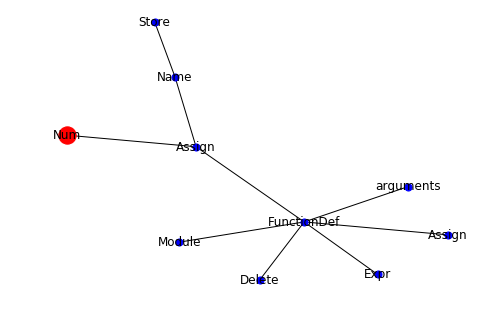

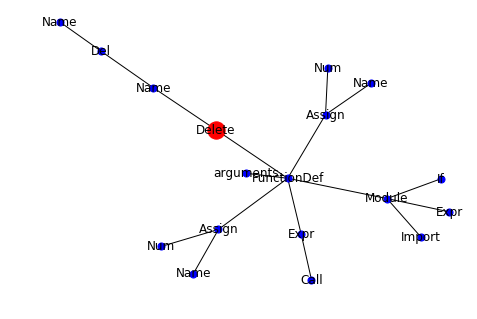

In [384]:
# Example usage 
for i in range(20):
    draw_egonet(i, radius=3)

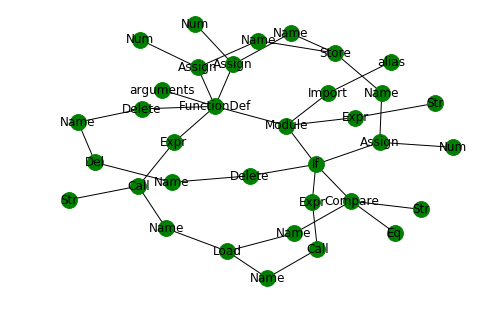

In [439]:
labels = {}
for n in G.nodes():
    labels[n] = get_name_from_token(feats[n], show_id=False)
pos = nx.layout.kamada_kawai_layout(G)
nx.draw(G, pos, node_color='g', node_size=250, with_labels=True, labels=labels)

In [386]:
def get_code_token(node_id):
    top_node, lineno, col_offset = source_map[str(node_id)]
    
    print("node_id =",node_id, "; top_node =",top_node)
    print("token_type =", get_name_from_token(feats[G.nodes()][node_id], show_id=False))


    ast_filename = file_map[str(top_node)]
    source_filename = parse_map[ast_filename]
    
    print()
    
    with open(source_filename[3:]) as f:
        for i, line in enumerate(f):
            if i+1 == lineno:
                print("Line", lineno, ":") 
                print("`", line.strip('\n'),"`")
                if col_offset != -1:
                    l = 0
                    for ls in line.split(): 
                        l += len(ls)
                        if l > col_offset:
                            print("\nToken =",ls)
                            break

In [335]:
get_code_token(3)

node_id = 3 ; top_node = 0
token_type = FunctionDef

Line 5 :
` import os `

Token = import


---

## Graph analysis

In [470]:
def draw_color_graph(G, measure):
    plt.figure(figsize=(15,15))
    pos = nx.layout.kamada_kawai_layout(G)
    labels = {}
    for n in G.nodes():
        labels[n] = get_name_from_token(feats[n], show_id=False)
    measures = color_list = [v for v in measure(G).values()]
    measure_name = measure.__name__
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.plasma, 
                                   node_color=measures,
                                   nodelist=G.nodes())
    
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)
    
    pos_labels = {}
    x_off, y_off = 0.05, 0.05

    for k, v in pos.items():
        pos_labels[k] = (v[0]+x_off, v[1]+y_off)
    
    nx.draw_networkx_labels(G,pos_labels,labels,font_size=16)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

/Users/Dylan/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


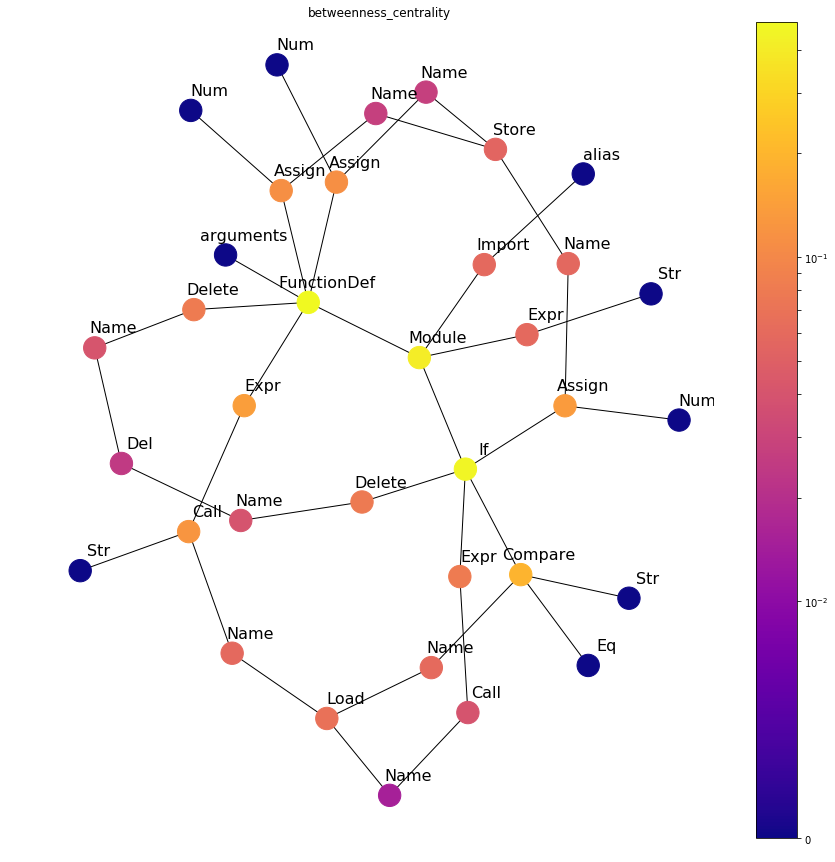

In [471]:
draw_color_graph(G, nx.betweenness_centrality)

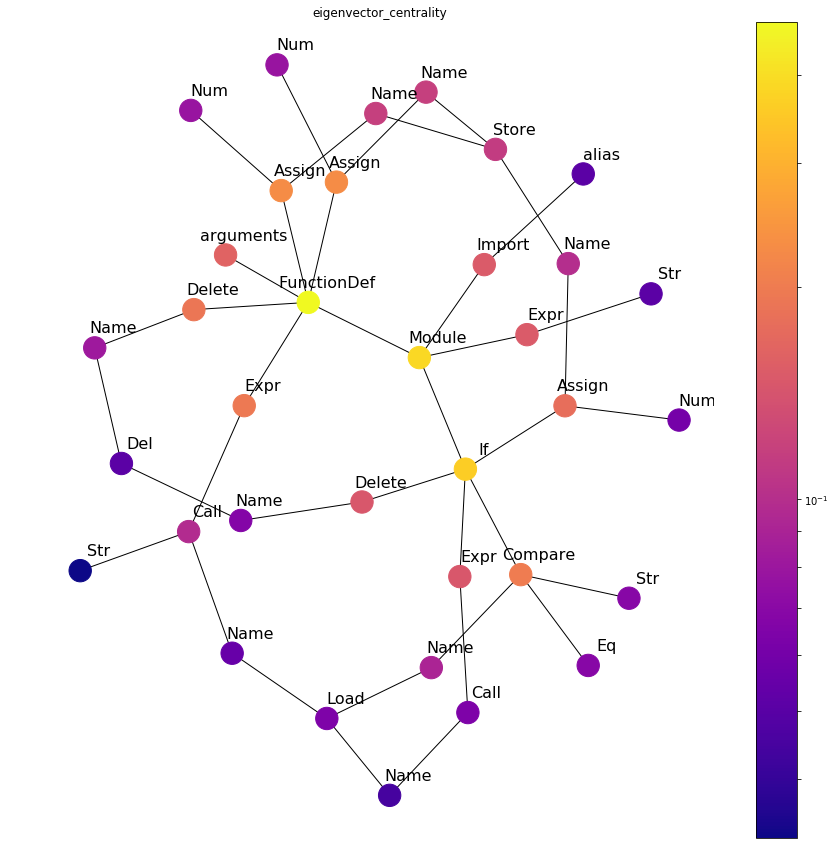

In [472]:
draw_color_graph(G, nx.eigenvector_centrality)

/Users/Dylan/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


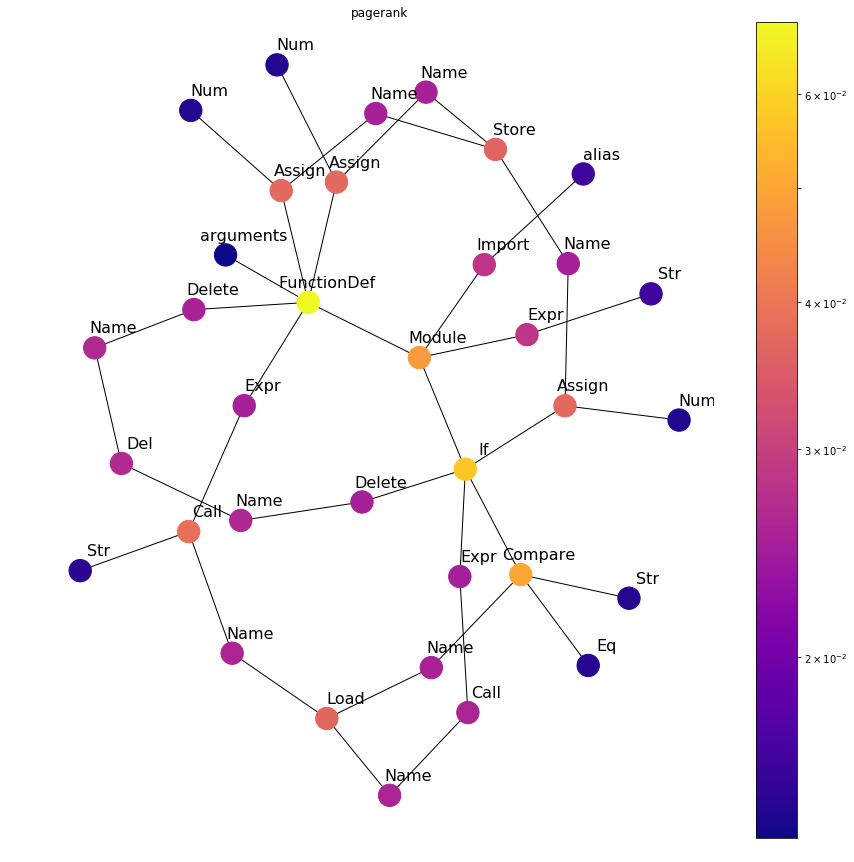

In [473]:
draw_color_graph(G, nx.pagerank)

/Users/Dylan/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


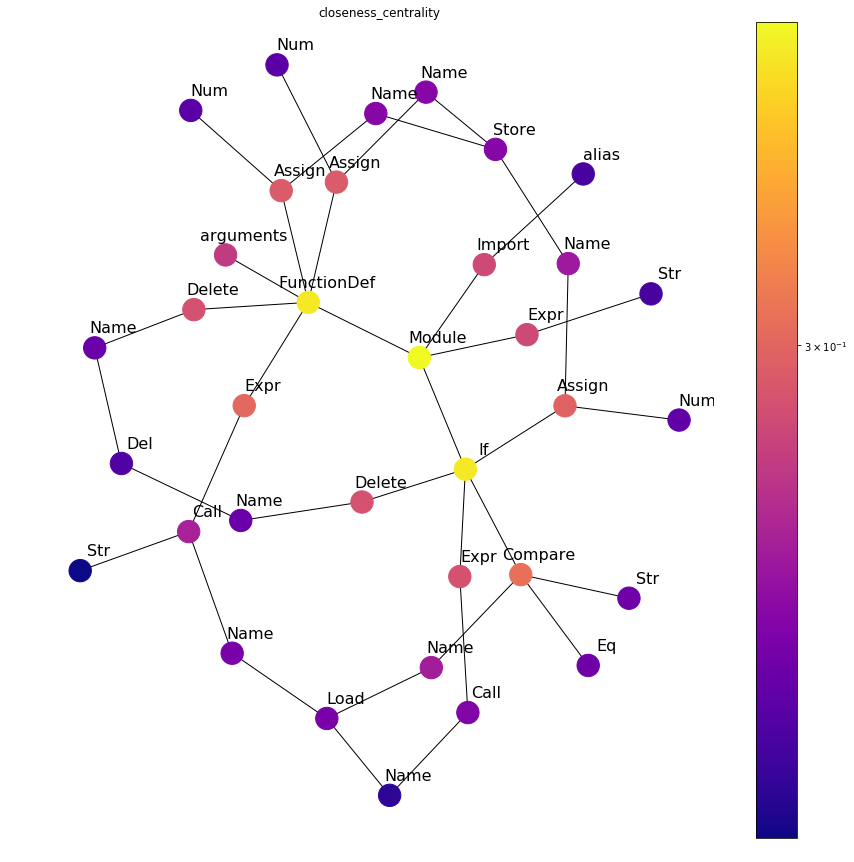

In [474]:
draw_color_graph(G, nx.closeness_centrality)